Copyright (C) 2023, Alexandre Didier, Jérôme Sieber, Rahel Rickenbach and Shao (Mike) Zhang, ETH Zurich,
{adidier,jsieber, rrahel}@ethz.ch

All rights reserved.

This code is only made available for students taking the advanced MPC 
class in the fall semester of 2023 (151-0371-00L) and is NOT to be 
distributed.

### Nominal Non-linear MPC

Programming Exercise 1. All graded tasks are given in the Problem Sheet. Required changes in the code are marked with "TODO".

In [1]:
# enable seamless adoption of changes to external python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from ampyc.params import NonlinearMPCParams
from ampyc.systems import NonlinearSystem
from ampyc.controllers import NonlinearMPC
from ampyc.plotting import plot_x_state_time, plot_x_state_state, plot_u, plot_nmpc, plot_costs
from ampyc.utils import Polytope

In [3]:
# set random seed
np.random.seed(0)

##### Get parameters and define system and controller

In [4]:
params = NonlinearMPCParams() #TODO: Specify parameters in separate file
sys = NonlinearSystem(params.sys)
ctrl = NonlinearMPC(sys, params.ctrl) #TODO: Implement NonlinearMPC in nonlinear_mpc.py

##### Simulate the closed-loop system for num_steps time steps and num_traj

In [5]:
# trajectories starting in x_0
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# control-loop
for i in range(num_traj):
    for j in range(num_steps):
        sol_u, sol_x, error_msg = ctrl.solve(x[j,:,i], additional_parameters={}, verbose=False)
        if error_msg != None:
            raise Exception(error_msg)
        u[j,i] = sol_u[0]
        x[j+1,:,i] = sys.step(x[j,:,i], u[j,i]).reshape(-1)

##### Plot Results

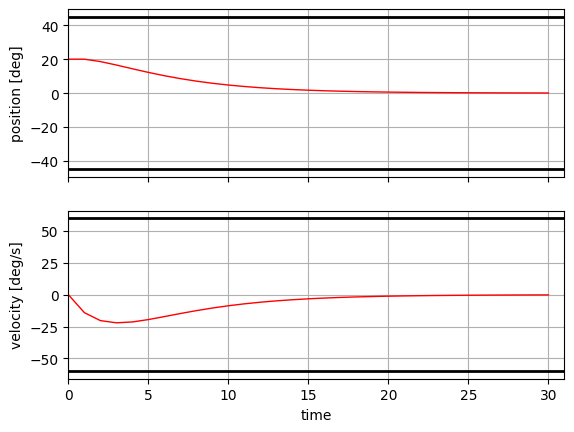

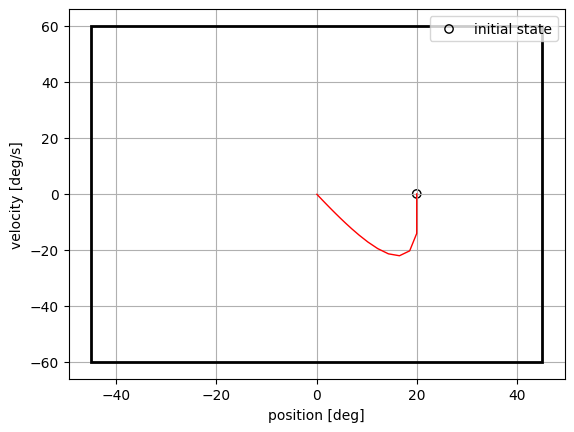

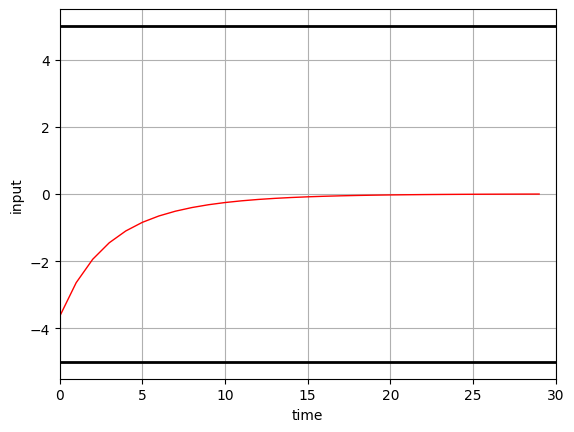

In [6]:
plot_x_state_time(1, x, sys.X, params.plot)
plot_x_state_state(2, x, sys.X, params.plot)
plot_u(3, u, sys.U, params.plot)

#### Exercise 2a
Simulate the disturbed system with multiple initial states & plot results

In [7]:
# create a nonlinear system with disturbance
b_w = np.array([0.3, 0.3, 1e-6, 1e-6]).reshape(-1,1)
A_w = params.sys.A_w
params.sys.noise_generator.reset(Polytope(A_w, b_w))

unc_sys = NonlinearSystem(params.sys)

In [8]:
# create a grid of initial conditions within the state constraints
lb, ub = unc_sys.X.bounding_box

GRID_SIZE = 15
dim_1, dim_2 = np.meshgrid(
    np.linspace(lb[0], ub[0], GRID_SIZE), np.linspace(lb[1], ub[1], GRID_SIZE))

x_0 = np.vstack([dim_1.ravel(), dim_2.ravel()])

In [9]:
# create a grid of initial conditions within the state constraints
GRID_SIZE = 15
grid = unc_sys.X.grid(GRID_SIZE**2)
x_0 = grid.reshape(GRID_SIZE**2,2).T 

In [10]:
# simulate for initial state grid; running this cell might take a while
num_steps = params.sim.num_steps
num_traj = x_0.shape[1]

# allocate state trajectories
unc_x = np.empty((num_steps+1,) + x_0.shape)
unc_x[:] = np.nan

# control-loop
for i in range(num_traj):
    unc_x[0,:,i] = x_0[:,i]
    for j in range(num_steps):
        sol_u, sol_x, error_msg = ctrl.solve(unc_x[j,:,i], additional_parameters={}, verbose=False)
        if error_msg != None:
            break
        u = sol_u[0]
        unc_x[j+1,:,i] = unc_sys.step(unc_x[j,:,i], u).reshape(-1)

In [ ]:
# identify unstable trajectories
infeas_traj = np.zeros(num_traj, dtype=bool)
for i in range(num_traj):
    if np.any(np.isnan(unc_x[:,:,i])):
        infeas_traj[i] = True

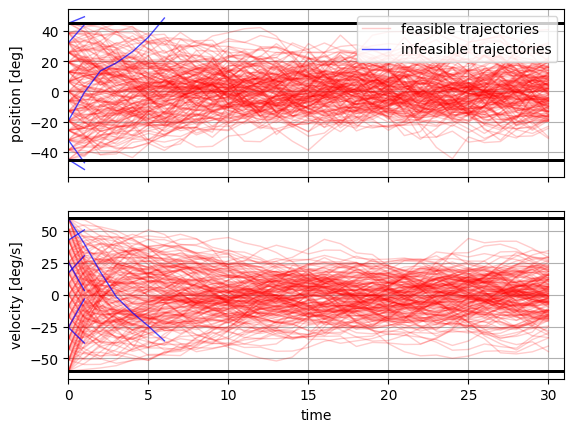

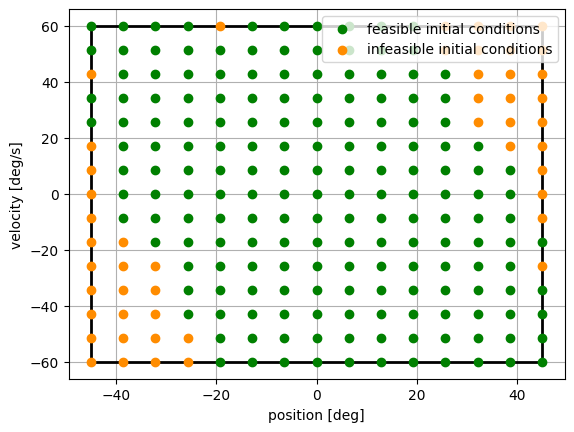

In [ ]:
# plot results of disturbed system
params.plot.color = 'red'
params.plot.alpha = 0.2
plot_x_state_time(4, unc_x[:,:,~infeas_traj], sys.X, params.plot, 'feasible trajectories')

# highlight unstable trajectories
params.plot.color = 'blue'
params.plot.alpha = 0.7
plot_x_state_time(4, unc_x[:,:,infeas_traj], sys.X, params.plot, 'infeasible trajectories')

# plot which initial conditions resulted in feasible or infeasible trajectories
plot_nmpc(5, x_0, infeas_traj, unc_sys.X)

#### Exercise 2b (robustness of nominal nonlinear MPC)
Test different initial states and disturbance sizes to get a feeling for the robustness of nominal nonlinear MPC.

In [22]:
#TODO: Change the values for initial state & disturbance size and observe how these two parameters affect the closed-loop trajectories and the cost decrease. 
#Also try to change the number of trajectories. This will compute multiple trajectories with different noise realizations starting from the same initial state.

# initial condition
x_0 = np.array([0.3, 0.2]).reshape(-1,1)

# play around with the size of the disturbance
b_w = np.array([0.4, 0.4, 1e-6, 1e-6]).reshape(-1,1)
#b_w = np.array([0.3, 0.3, 1e-6, 1e-6]).reshape(-1,1)
A_w = params.sys.A_w
params.sys.noise_generator.reset(Polytope(A_w, b_w))

unc_sys = NonlinearSystem(params.sys)

In [23]:
num_steps = params.sim.num_steps
num_traj = 40

# allocate state trajectories
unc_x = np.empty((num_steps+1, x_0.shape[0], num_traj))
unc_x[:] = np.nan
unc_x[0,:,:] = x_0
opt_cost = np.empty((num_steps+1, num_traj))
opt_cost[:] = np.nan

# control loop
for i in range(num_traj):
    for j in range(num_steps):
        sol_u, sol_x, error_msg = ctrl.solve(unc_x[j,:,i], additional_parameters={}, verbose=False)
        if error_msg != None:
            break
        u = sol_u[0]
        unc_x[j+1,:,i] = unc_sys.step(unc_x[j,:,i], u).reshape(-1)
        opt_cost[j,i] = ctrl.prob.value(ctrl.objective)

In [24]:
# identify unstable trajectories
infeas_traj = np.zeros(num_traj, dtype=bool)
for i in range(num_traj):
    if np.any(np.isnan(unc_x[:,:,i])):
        infeas_traj[i] = True

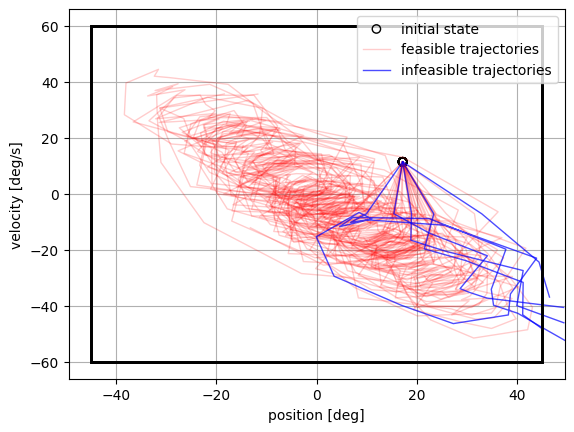

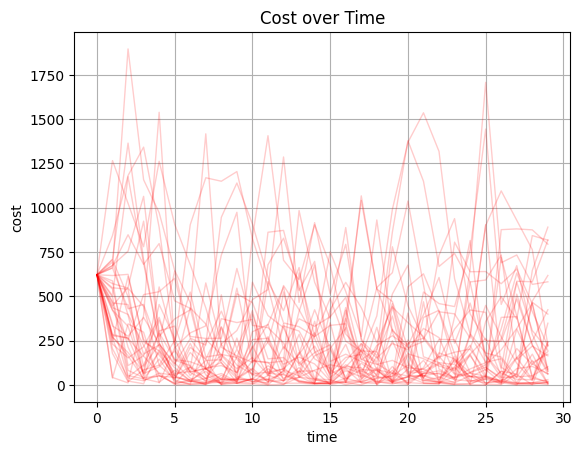

In [25]:
# plot results
params.plot.color = 'red'
params.plot.alpha = 0.2
plot_x_state_state(6, unc_x[:,:,~infeas_traj], sys.X, params.plot, 'feasible trajectories')

params.plot.color = 'blue'
params.plot.alpha = 0.7
plot_x_state_state(6, unc_x[:,:,infeas_traj], sys.X, params.plot, 'infeasible trajectories')

params.plot.color = 'red'
params.plot.alpha = 0.2
plot_costs(7, opt_cost[:,~infeas_traj], params.plot)